In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy

from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator
from qiskit.extensions import RXGate, RYGate, RZGate

In [2]:
def generar_mapa():
    a = 0
    while (np.linalg.matrix_rank(a)!=n1):
        a = np.random.randint(n3, size=(n1,n1))
        np.fill_diagonal(a,0)
        a = np.tril(a) + np.tril(a, -1).T
    return a

def generar_red(a):
    net1 = nx.from_numpy_matrix(copy.deepcopy(a))
    for e in net1.edges():
        net1[e[0]][e[1]]['color'] = 'black'
    edge_weights_list = [net1[e[0]][e[1]]['weight'] for e in net1.edges()]
    return net1, edge_weights_list

def generar_paquetes(n1,n2):
    moves = np.zeros([n2, 2])    
    rng = np.random.default_rng()
    for i in range(n2):
        moves[i,:] = rng.choice(n1, size=2, replace=False)    
    colores = []
    for i in range(n2):
        color = np.base_repr(np.random.choice(16777215), base=16)
        colores.append('#{:0>6}'.format(color))
    
    return moves, colores

def caminos(net1, moves):
    caminitos = []
    i = 0
    for j in range(len(moves)):
        cam = []
        try:
            p = nx.dijkstra_path(net1,int(moves[j,0]),int(moves[j,1]))
            #print("{:0>3} - Para llegar desde {} hasta {} hay que hacer el siguiente camino: {}".format(j, moves[j,0],moves[j,1], p))        
            for e in range(len(p)-1):
                cam.append(tuple(sorted((p[e], p[e+1]))))    
        except:
            i += 1
            #print("{:0>3} - NO SE PUEDE CONECTAR EL PUNTO {} CON EL PUNTO {}.".format(j+1, int(moves[j,0]),int(moves[j,1])))  
            if i == len(moves):
                return caminitos, True        
        caminitos.append(cam)
    return caminitos, False

def paquetes_en_ruta(caminos, ruta):
    lista = []
    for i in range(n2):
        if ruta in caminos[i]:
            lista.append(i)
    return lista

def opciones_clas(n):
    if n == 1:
        a = {'1': 1}
        x = [a]
    elif n == 2:
        a0 = {'00': 1}
        a1 = {'01': 1}
        a2 = {'10': 1}
        a3 = {'11': 1}
        x = [a0, a1, a2, a3]
    return np.random.choice(x) 
    

def crear_circuito(n):
    I_f = I = np.array([[1, 0],
                  [0, 1]])
    X_f = X = np.array([[0, 1],
                  [1, 0]])    
    for q in range(n-1):
        I_f = np.kron(I_f, I)
        X_f = np.kron(X_f, X)
    J = Operator(1 / np.sqrt(2) * (I_f + 1j * X_f))    
    J_dg = J.adjoint()
    
    if n==1:
        dx = np.pi
        dy = 0
        dz = 0
    elif n==2:    
        dx = np.pi/2
        dy = np.pi/4
        dz = 0

    circ = QuantumCircuit(n,n)
    circ.append(J, range(n))
    for q in range(n):
        circ.append(RXGate(dx),[q])
        circ.append(RYGate(dy),[q])
        circ.append(RZGate(dz),[q])            
    circ.append(J_dg, range(n))
    circ.measure(range(n), range(n))  
    return circ

def juego(lista, tipo):
    m = len(lista)
    if m > 0:
        for r in range(int(np.ceil(np.log2(m)))):
            ganadores = []            
            for j in range(int(np.ceil(m/2))):
                jug = 2 - int(m == j+int(np.ceil(m/2)))
                if tipo == 'c':
                    measurement = opciones_clas(jug)
                        
                elif tipo == 'q':
                    circ = crear_circuito(jug)
                    backend = Aer.get_backend('qasm_simulator')
                    job = execute(circ, backend=backend, shots=1)
                    result = job.result()
                    measurement = result.get_counts(circ)
                
                for k,i in enumerate(list(measurement.keys())[0]):
                    if i=='1':
                        ganadores.append(lista[2*j + k])                    
            lista = ganadores   
            m = len(lista)         
    return lista

RESULTADOS DEL JUEGO CLÁSICO:

Uso de rutas: [2. 3. 1. 1. 2. 1. 2. 1. 2. 1. 2. 3. 2. 3. 2. 2. 1. 1. 1. 1.]
Total de rutas: 34/20
Envíos: 15/50
Kilometros: 68.0
Coste final = Envíos/Kilometros = 0.22058823529411764


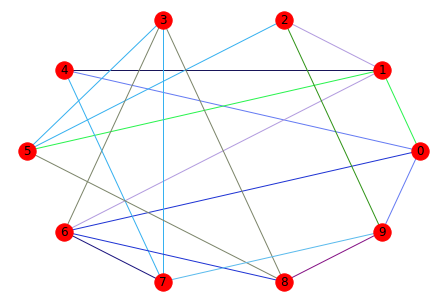

In [62]:
n1 = 10    # cantidad de ciudades
n2 = 50    # cantidad de viajes
n3 = 2     # distancia máxima

a = generar_mapa()                            # genero matriz
net1, edge_weights_list = generar_red(a)      # genero red
net2, edge_weights_list = generar_red(a)      # genero copia de red
moves, colores = generar_paquetes(n1,n2)      # genero paquetes

caminitos, flag = caminos(net1, moves)
all_edges2 = [e for e in net2.edges]
veces = np.zeros(len(all_edges2))
i = rutas = kilom = envio = coste = 0
tipo = 'c' # elegir entre clásico ('c') y cuántico ('q')
while not flag:
    all_edges = [e for e in net1.edges]
    paquetes_ruta = paquetes_en_ruta(caminitos, all_edges[i])
    #print("Todas las rutas", all_edges)
    #print("Rutas de cada paquete:", caminitos)
    #print("Ruta disputada:",all_edges[i])
    #print("Paquetes que disputan:", paquetes_ruta)
    if paquetes_ruta == []:
        i += 1
    else:
        i = 0
        ganadores = juego(paquetes_ruta, tipo)
        #print("Ganadores:",ganadores, "\n")
        for x in range(len(ganadores)):
            envio += 1
            moves[ganadores[x]] = [-1,-2]
            for y in caminitos[ganadores[x]]:
                rutas += 1
                veces[np.where((np.array(all_edges2) == y).all(axis=1))[0][0]] += 1
                kilom += 2 * net2[y[0]][y[1]]['weight'] * veces[np.where((np.array(all_edges2) == y).all(axis=1))[0][0]] - 1
                net1.remove_edges_from([y])
                net2[y[0]][y[1]]['color'] = colores[envio]
        caminitos, flag = caminos(net1, moves)

if tipo == 'c':
    print("RESULTADOS DEL JUEGO CLÁSICO:\n")
elif tipo == 'q':
    print("RESULTADOS DEL JUEGO CUÁNTICO:\n")
    
print("Uso de rutas:", veces)
print("Total de rutas: {}/{}".format(rutas,len(all_edges2)))
print("Envíos: {}/{}".format(envio, n2))
print("Kilometros:",kilom)
print("Coste final = Envíos/Kilometros = {}".format(envio/kilom))

edge_color_list = [net2[e[0]][e[1]]['color'] for e in net2.edges()]
edge_weights_list = [net2[e[0]][e[1]]['weight'] for e in net2.edges()]
nx.draw_circular(net2,node_color='red',edge_color = edge_color_list, with_labels = True, width=edge_weights_list)
plt.show()